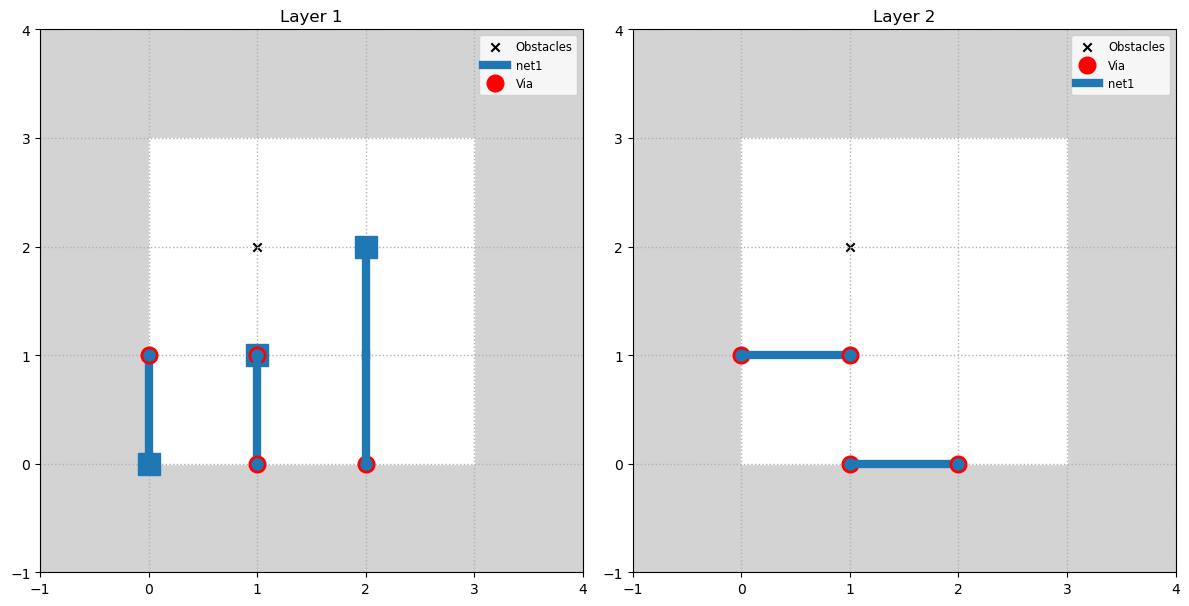

In [91]:
import matplotlib.pyplot as plt
import re
def parse_input_file(file_path):
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    grid_line = lines[0]
    grid_width, grid_height, *other_params = map(int, grid_line.split(','))
    obs_lines = []
    pin_lines = []
    for line in lines[1:]:
        if line.startswith("OBS"):
            obs_lines.append(line)
        else:
            pin_lines.append(line) 
    obstacles = []
    for line in obs_lines:
        match = re.search(r'\((\d+),\s*(\d+)\)', line)
        if match:
            obstacles.append(tuple(map(int, match.groups())))

    pins = []
    net_names = []
    for line in pin_lines:
        tokens = line.split()
        net_names.append(tokens[0])
        coords = re.findall(r'\((\d+),\s*(\d+),\s*(\d+)\)', line)
        net = [tuple(map(int, c)) for c in coords]
        if net:
            pins.append(net)

    return (grid_width, grid_height), obstacles, pins, net_names

def parse_output_file(filename):
    output_nets = []
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    
    for line in lines:
        tokens = line.split()
        coords = re.findall(r'\((\d+),\s*(\d+),\s*(\d+)\)', line)
        net = [tuple(map(int, c)) for c in coords]
        if net:
            output_nets.append(net)
    
    return output_nets

def visualize(grid_size, obstacles, input_nets, output_nets, net_names=None):
    layers_used = sorted(set(pt[0] for net in output_nets for pt in net))
    transition_color = 'red'

    fig, axs = plt.subplots(1, len(layers_used), figsize=(6 * len(layers_used), 6))
    if len(layers_used) == 1:
        axs = [axs]

    layer_to_ax = {}
    for ax, layer in zip(axs, layers_used):
        layer_to_ax[layer] = ax
        ax.set_title(f"Layer {layer}")
        padding = 1
        ax.set_xlim(-padding, grid_size[0] +padding)
        ax.set_ylim(-padding, grid_size[1]+padding)
        #ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.grid(True, linestyle=':', linewidth=1)
        ax.add_patch(plt.Rectangle((-padding, -padding), grid_size[0] + 2*padding, grid_size[1] + 2*padding,
                                  color='lightgray', zorder=-1))
        ax.add_patch(plt.Rectangle((0, 0), grid_size[0], grid_size[1], color='white', zorder=0))
        if obstacles:
            ox, oy = zip(*obstacles)
            ax.scatter(ox, oy, color='black', marker='x', label='Obstacles')

    cmap = plt.colormaps.get_cmap('tab20')
    legend_added = set()
    for net_idx, net in enumerate(input_nets):
        net_color = cmap(net_idx)
        net_label = net_names[net_idx] if net_names else f"net{net_idx + 1}"
        #print(net_label)
        for (layer, x, y) in net:
            ax = layer_to_ax.get(layer)
            if ax:
                ax.plot(x, y, marker='s', color=net_color, markersize=16,
                        linestyle='None')
        legend_added.add(net_label)
    for net_idx, net in enumerate(output_nets):
        net_color = cmap(net_idx)
        net_label = net_names[net_idx] if net_names else f"net{net_idx + 1}"

        for i in range(len(net) - 1):
            l1, x1, y1 = net[i]
            l2, x2, y2 = net[i + 1]

            if l1 == l2:
                ax = layer_to_ax[l1]
                ax.plot([x1, x2], [y1, y2], color=net_color, linewidth=6,
                        label=net_label if (l1, net_label) not in legend_added else "")
                legend_added.add((l1, net_label))
            else:
                #if i>0:
                    for l in [l1, l2]:
                        ax = layer_to_ax.get(l)
                        if ax:
                            ax.plot(x2, y2, marker='o', color=transition_color, markersize=12,
                                    linestyle='None', label='Via' if ('via', l) not in legend_added else "")
                            ax.plot(x2, y2, marker='o', color=net_color, markersize=8,
                                    linestyle='None')
                            legend_added.add(('via', l))
    for ax in axs:
        ax.legend(loc='upper right', fontsize='small')


    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    input_filename = "input.txt"
    output_filename = "output.txt"

    grid_size, obstacles, input_nets, net_names = parse_input_file(input_filename)
    output_nets = parse_output_file(output_filename)
    #print(len(net_names))
    #print(len(output_nets))
    visualize(grid_size, obstacles, input_nets, output_nets, net_names)

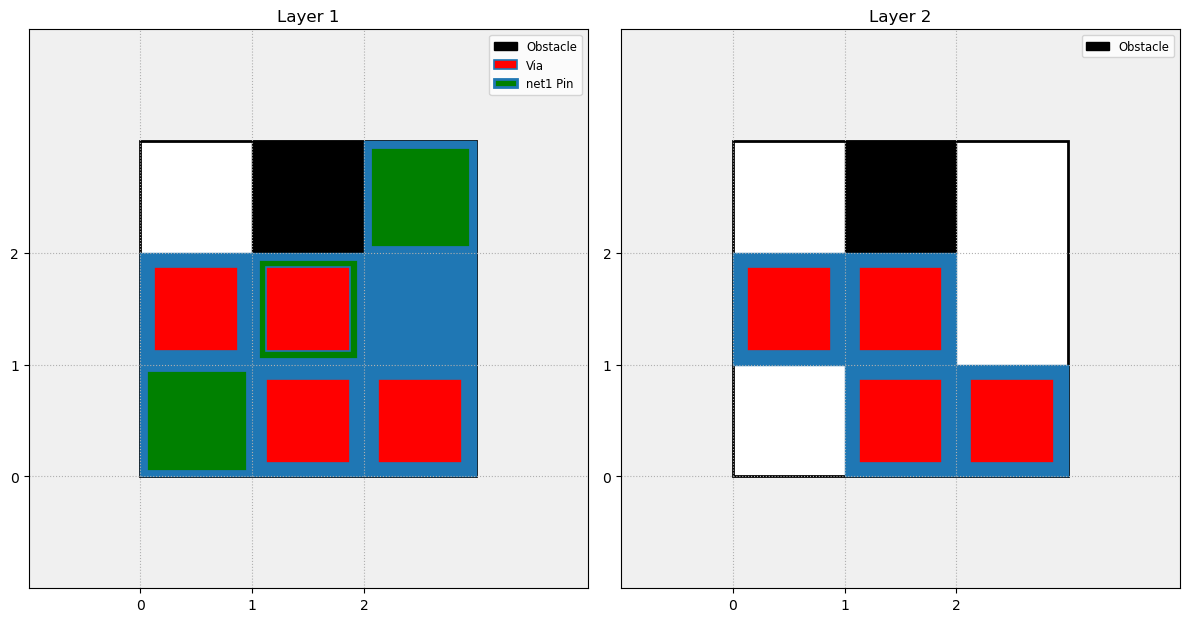

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import re

def parse_input_file(file_path):
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    grid_line = lines[0]
    grid_width, grid_height, *_ = map(int, grid_line.split(','))
    obs_lines, pin_lines = [], []
    for line in lines[1:]:
        if line.startswith("OBS"):
            obs_lines.append(line)
        else:
            pin_lines.append(line)
    obstacles = [tuple(map(int, re.search(r'\((\d+),\s*(\d+)\)', l).groups())) for l in obs_lines]
    pins, net_names = [], []
    for line in pin_lines:
        tokens = line.split()
        net_names.append(tokens[0])
        coords = re.findall(r'\((\d+),\s*(\d+),\s*(\d+)\)', line)
        pins.append([tuple(map(int, c)) for c in coords])
    return (grid_width, grid_height), obstacles, pins, net_names

def parse_output_file(filename):
    output_nets = []
    with open(filename, 'r') as f:
        for line in f:
            coords = re.findall(r'\((\d+),\s*(\d+),\s*(\d+)\)', line)
            output_nets.append([tuple(map(int, c)) for c in coords])
    return output_nets

def visualize(grid_size, obstacles, input_nets, output_nets, net_names=None):
    grid_width, grid_height = grid_size
    all_layers = sorted(set(p[0] for net in output_nets for p in net))
    cmap = plt.colormaps.get_cmap('tab20')
    fig, axs = plt.subplots(1, len(all_layers), figsize=(6 * len(all_layers), 6))

    if len(all_layers) == 1:
        axs = [axs]
    layer_to_ax = dict(zip(all_layers, axs))

    for ax, layer in zip(axs, all_layers):
        ax.set_title(f"Layer {layer}")
        ax.set_xlim(-1, grid_width + 1)
        ax.set_ylim(-1, grid_height + 1)
        ax.set_aspect('equal')
        ax.set_xticks(range(grid_width))
        ax.set_yticks(range(grid_height))
        ax.grid(True, linestyle=':', linewidth=0.8)
        ax.set_facecolor('#f0f0f0')
        ax.add_patch(patches.Rectangle(
            (0, 0), grid_width, grid_height,
            edgecolor='black', facecolor='white', linewidth=2, zorder=0
        ))
    for (ox, oy) in obstacles:
        for ax in axs:
            ax.add_patch(patches.Rectangle(
                (ox, oy), 1, 1,
                color='black', label='Obstacle', zorder=1
            ))

    used_labels = set()
    for net_idx, net in enumerate(output_nets):
        color = cmap(net_idx)
        label = net_names[net_idx] if net_names else f"net{net_idx+1}"
        for (layer, x, y) in net:
            ax = layer_to_ax[layer]
            key = (layer, x, y, 'route')
            if key not in used_labels:
                ax.add_patch(patches.Rectangle((x, y), 1, 1, color=color, zorder=1))
                used_labels.add(key)

    for net_idx, net in enumerate(output_nets):
        net_color = cmap(net_idx)
        for i in range(len(net) - 1):
            l1, x1, y1 = net[i]
            l2, x2, y2 = net[i + 1]
            if l1 != l2:
                for l in [l1, l2]:
                    ax = layer_to_ax.get(l)
                    if ax:
                        label = "Via" if "Via" not in used_labels else None
                        ax.add_patch(patches.Rectangle(
                            (x2 + 0.125, y2 + 0.125), 0.75, 0.75,
                            linewidth=1.2,
                            edgecolor=net_color,
                            facecolor='red',
                            zorder=6,
                            label=label
                        ))
                        used_labels.add("Via")
    for net_idx, net in enumerate(input_nets):
        color = cmap(net_idx)
        label = f"{net_names[net_idx]} Pin" if net_names else f"Net{net_idx+1} Pin"
        for (layer, x, y) in net:
            ax = layer_to_ax.get(layer)
            if ax:
                ax.add_patch(patches.Rectangle(
                    (x + 0.05, y + 0.05), 0.9, 0.9, linewidth=2, edgecolor=color,
                    facecolor='green', zorder=4,
                    label=label if label not in used_labels else None
                ))
                used_labels.add(label)


    for ax in axs:
        ax.legend(loc='upper right', fontsize='small')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    input_file = "input.txt"
    output_file = "output.txt"
    grid_size, obstacles, input_nets, net_names = parse_input_file(input_file)
    output_nets = parse_output_file(output_file)
    visualize(grid_size, obstacles, input_nets, output_nets, net_names)


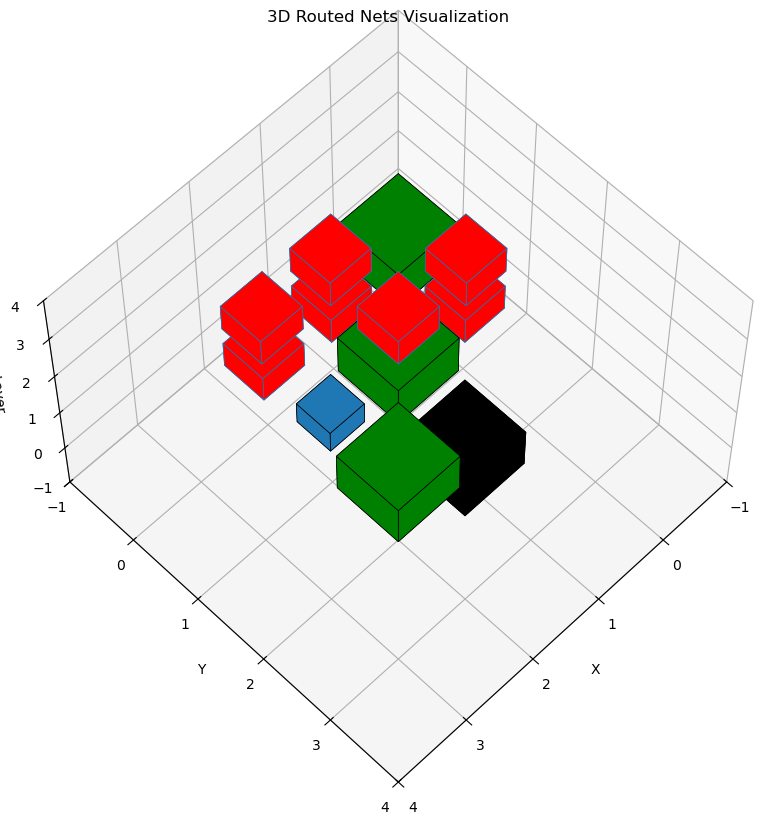

In [119]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import re

def parse_input_file(file_path):
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    grid_line = lines[0]
    grid_width, grid_height, *_ = map(int, grid_line.split(','))
    
    obs_lines, pin_lines = [], []
    for line in lines[1:]:
        if line.startswith("OBS"):
            obs_lines.append(line)
        else:
            pin_lines.append(line)

    obstacles = []
    for line in obs_lines:
        match = re.search(r'\((\d+),\s*(\d+)\)', line)
        if match:
            obstacles.append(tuple(map(int, match.groups())))

    pins, net_names = [], []
    for line in pin_lines:
        net_names.append(line.split()[0])
        coords = re.findall(r'\((\d+),\s*(\d+),\s*(\d+)\)', line)
        pins.append([tuple(map(int, c)) for c in coords])

    return (grid_width, grid_height), obstacles, pins, net_names

def parse_output_file(file_path):
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    routed_nets = []
    for line in lines:
        coords = re.findall(r'\((\d+),\s*(\d+),\s*(\d+)\)', line)
        routed_nets.append([tuple(map(int, c)) for c in coords])
    return routed_nets

def draw_cube(ax, x, y, z, size=1, color='blue', alpha=1.0, edgecolor='black'):
    # Create a cube centered at (x, y, z)
    r = size / 2
    # Define 8 vertices
    vertices = [[x - r, y - r, z - r], [x + r, y - r, z - r],
                [x + r, y + r, z - r], [x - r, y + r, z - r],
                [x - r, y - r, z + r], [x + r, y - r, z + r],
                [x + r, y + r, z + r], [x - r, y + r, z + r]]
    # Define cube faces
    faces = [[vertices[j] for j in [0, 1, 2, 3]],
             [vertices[j] for j in [4, 5, 6, 7]],
             [vertices[j] for j in [0, 1, 5, 4]],
             [vertices[j] for j in [2, 3, 7, 6]],
             [vertices[j] for j in [1, 2, 6, 5]],
             [vertices[j] for j in [4, 7, 3, 0]]]
    ax.add_collection3d(Poly3DCollection(faces, facecolors=color, edgecolors=edgecolor, linewidths=0.5, alpha=alpha))

def visualize_3d(grid_size, obstacles, pins, routes, net_names=None):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    max_layer = max(pt[0] for net in routes for pt in net)
    max_x, max_y = grid_size

    # Draw obstacles
    for (x, y) in obstacles:
        draw_cube(ax, x, y, 0, size=0.9, color='black')

    cmap = plt.colormaps.get_cmap('tab20')
    for net_idx, net in enumerate(routes):
        color = cmap(net_idx)
        for i, (layer, x, y) in enumerate(net):
            draw_cube(ax, x, y, layer, size=0.5, color=color)

            # Check for via (layer change)
            if i > 0:
                prev_layer, px, py = net[i - 1]
                if (px, py) == (x, y) and layer != prev_layer:
                    # Draw a vertical red "via"
                    z_min, z_max = sorted([layer, prev_layer])
                    for z in range(z_min, z_max + 1):
                        draw_cube(ax, x, y, z, size=0.6, color='red', edgecolor=color)

    # Draw pins (as green larger cubes)
    for net_idx, net in enumerate(pins):
        color = 'green'
        for layer, x, y in net:
            draw_cube(ax, x, y, layer, size=0.9, color=color)

    ax.set_xlim([-1, max_x + 1])
    ax.set_ylim([-1, max_y + 1])
    ax.set_zlim([-1, max_layer + 2])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Layer")
    ax.set_title("3D Routed Nets Visualization")
    ax.view_init(elev=60, azim=45)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    input_file = "input.txt"
    output_file = "output.txt"
    grid_size, obstacles, pins, net_names = parse_input_file(input_file)
    routes = parse_output_file(output_file)
    visualize_3d(grid_size, obstacles, pins, routes, net_names)


In [75]:
cmap = plt.colormaps.get_cmap('tab20')